#

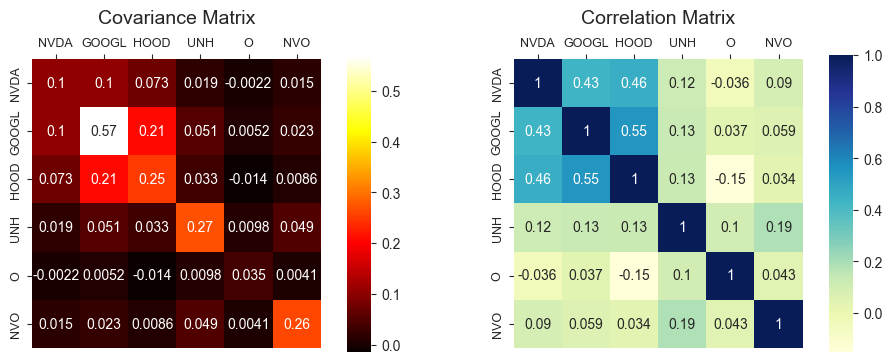

In [72]:
from logReturns import logReturns
import matplotlib.pyplot as plt
from seaborn import heatmap

tickers = "NVDA GOOGL HOOD UNH O NVO"
period = "1y" #one of: [1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max]

logs = logReturns(tickers, period)
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(11), fig.set_figwidth(11)
heatmap(logs.cov()*252, ax = ax1, annot = True, cmap = "hot", cbar = True, square = True, xticklabels = tickers.split(" "), yticklabels = tickers.split(" "), cbar_kws = {"shrink":0.34, "aspect":12, "pad":0.07})
heatmap(logs.corr(), ax = ax2, annot = True, cmap = "YlGnBu", cbar = True, square = True, xticklabels = tickers.split(" "), yticklabels = tickers.split(" "), cbar_kws = {"shrink":0.34, "aspect":12, "pad":0.07})
fig.subplots_adjust(wspace = 0.3)
ax1.xaxis.tick_top(), ax2.xaxis.tick_top(), ax1.yaxis.tick_left(), ax2.yaxis.tick_left()
ax1.tick_params(axis = "both", labelsize = 9), ax2.tick_params(axis = "both", labelsize = 9)
ax1.set_title("Covariance Matrix", fontdict = {"fontsize":14}, pad = 10), ax2.set_title("Correlation Matrix", fontdict = {"fontsize":14}, pad = 10)
ax1.set_xlabel(""), ax2.set_xlabel(""), ax1.set_ylabel(""), ax2.set_ylabel("");

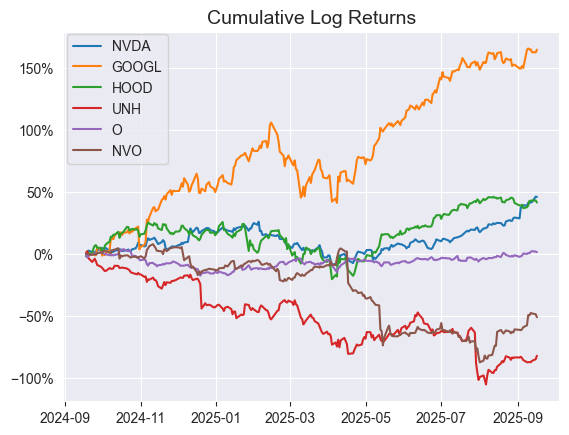

In [109]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from logReturns import logReturns

tickers = "NVDA GOOGL HOOD UNH O NVO"
period = "1y" #one of: [1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max]

logs = logReturns(tickers, period).cumsum()
#standard = np.exp(logs)-1
fig, ax = plt.subplots()
ax.plot(logs)
ax.set_title("Cumulative Log Returns",fontdict = {"fontsize":14})
fig.legend(labels = tickers.split(" "), loc = "upper left", bbox_to_anchor = (0.12,0.89))
ax.xaxis.tick_bottom()
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))

In [111]:
import numpy as np
import yfinance as yf
from pandas import DataFrame
from logReturns import logReturns
from vol import vol
rng = np.random.default_rng()

port_value = 10000 #USD
rf = 0.04 #risk-free rate
tickers = "NVDA GOOGL HOOD UNH O NVO"

randoms = rng.integers(low = 1000, high = 5000, size = len(tickers.split(" ")))
values = port_value*randoms/sum(randoms)
close = yf.Tickers(tickers).history(period = "1d", progress = False)["Close"].iloc[-1,:]
port = DataFrame(index = tickers.split(" ")) #random weighted portfolio of symbols in tickers
logs = logReturns(tickers,"1y")
port["Position"] = np.floor_divide(values,close,dtype = "int64", casting = "unsafe")
port["Log Return"] = logs.sum().round(3)
port["Volatility"] = vol(tickers,"1y")[1].round(3)
port["Weight"] = ((port["Position"]*close)/sum(port["Position"]*close)).round(3)
port_log = (port["Log Return"]*port["Weight"]).sum()
port_real = np.exp(port_log)-1
port_variance = np.dot(port["Weight"].T,np.dot(logs.cov()*252,port["Weight"]))
print(f"{port}\n--\nLog return: {"{:.2%}".format(port_log)}\n"
      f"Volatility: {"{:.2%}".format(np.sqrt(port_variance))}\n"
      f"Sharpe: {((port_real-rf)/np.sqrt(port_variance)).round(3)}")

       Position  Log Return  Volatility  Weight
NVDA          2       0.414       0.499   0.036
GOOGL         5       0.460       0.321   0.131
HOOD         20       1.646       0.756   0.245
UNH           4      -0.510       0.511   0.142
O            35       0.015       0.186   0.219
NVO          38      -0.820       0.518   0.227
--
Log Return: 22.32%
Volatility: 26.62%
Sharpe: 0.789


     Value  GOOGL  HOOD  NVDA  NVO   O  UNH  Log Return  Volatility    Sharpe
0  9522.86      5    22     4   26  13    8    0.264923    0.325577  0.808811
1  9709.26      4    15     5   46  29    5    0.074479    0.279895  0.133345
2  9589.34      3    22    10   12  41    4    0.427699    0.304415  1.621878
3  9334.82      7    12     8   32  32    3    0.183530    0.258765  0.623932
4  9532.00      9    20    11   21  13    3    0.441252    0.327804  1.569999
--
Mean log return: 20.45%
Mean volatility: 27.92%
Mean Sharpe: 0.677


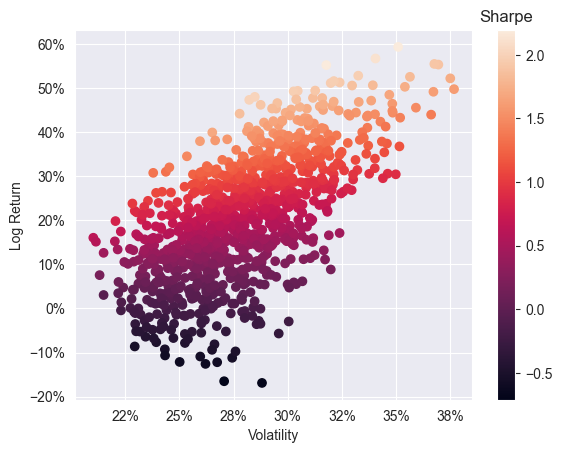

In [123]:
import numpy as np
import pandas as pd
import yfinance as yf
from logReturns import logReturns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import ticker
rng = np.random.default_rng()

port_value = 10000 #USD
no_ports = 1000
rf = 0.04 #risk-free rate
tickers = "NVDA GOOGL HOOD UNH O NVO"

randoms = rng.integers(low = 1000, high = 5000, size = (no_ports,len(tickers.split(" "))))
values = port_value*(randoms/randoms.sum(axis = 1).reshape(no_ports,1))
close = np.array(yf.Tickers(tickers).history(period = "1d", progress = False)["Close"].iloc[-1,:])
position = DataFrame(np.floor_divide(values,close,dtype = "int64",casting = "unsafe"), columns = sorted(tickers.split(" ")))
logs = logReturns(tickers, "1y")
log_return = np.array(logs.sum()).reshape(1,np.shape(logs.sum())[0])
weight = (position*close)/np.array((position*close).sum(axis = 1)).reshape(no_ports,1)
port_returns = weight.dot(log_return.T)
ports = DataFrame({"Value":(position*close).sum(axis = 1).round(2)}).join(position)
ports["Log Return"] = port_returns
ports["Volatility"] = np.sqrt(np.diag(np.dot(weight,np.dot(logs.cov()*252,weight.T))))
ports["Sharpe"] = (np.exp(ports["Log Return"]) - 1 - rf)/ports["Volatility"]
pd.set_option('display.expand_frame_repr', False)
print(ports.head())

fig, ax = plt.subplots()
plot = ax.scatter(ports["Volatility"], ports["Log Return"], c = ports["Sharpe"])
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1, decimals = 0))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1, decimals = 0))
ax.set_xlabel("Volatility")
ax.set_ylabel("Log Return")
clb = fig.colorbar(plot)
clb.ax.set_title("Sharpe")

print(f"--\n"
      f"Mean log return: {"{:.2%}".format(ports["Log Return"].mean())}\n"
      f"Mean volatility: {"{:.2%}".format(ports["Volatility"].mean())}\n"
      f"Mean Sharpe: {ports["Sharpe"].mean().round(3)}")